<a href="https://colab.research.google.com/github/czhurdlespeed/TFDevCert/blob/main/TFCert_Practice/05_transfer_learning_in_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TF: Fine-tuning

In [1]:
# Check for GPU
!nvidia-smi

Wed Jan 10 15:13:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-10 15:14:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-10 15:14:58 (92.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Use python modules to reuse functions
* Import them as modules

In [3]:
# Import Helper Functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


## Let's get some data
Use `tf.keras.applications`

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")


--2024-01-10 15:20:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   157MB/s    in 1.0s    

2024-01-10 15:20:31 (157 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out images and subdirectories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See example of a batch off data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[7.87244892e+00 2.87244892e+00 6.87244892e+00]
   [6.59693909e+00 4.59693909e+00 7.59693909e+00]
   [6.00000000e+00 4.00000000e+00 7.00000000e+00]
   ...
   [5.57654476e+00 9.79080868e+00 1.12193365e+01]
   [1.17857275e+01 7.64284420e+00 8.57140255e+00]
   [1.50714283e+01 6.35714293e+00 4.71428585e+00]]

  [[8.00000000e+00 4.00000000e+00 5.00000000e+00]
   [6.99489784e+00 4.99489784e+00 5.99489784e+00]
   [6.72959185e+00 4.72959185e+00 5.72959185e+00]
   ...
   [4.96939087e+00 5.08673286e+00 7.07142830e+00]
   [6.21940136e+00 6.00000000e+00 5.92854500e+00]
   [7.23979759e+00 5.97448730e+00 4.07142830e+00]]

  [[7.00000000e+00 5.21428585e+00 5.57142830e+00]
   [7.92857170e+00 6.14285755e+00 6.50000000e+00]
   [6.00000000e+00 6.00000000e+00 5.57142830e+00]
   ...
   [1.28060265e+01 4.18881416e+00 6.61734200e+00]
   [5.88263178e+00 6.05613279e+00 5.98469114e+00]
   [2.21425056e+00 7.35717773e+00 5.78571415e+00]]

  ...

  [[1.55362244e+02 1.38147980e+02 1.18147972e+02]
   [1

## Model 0: Transfer learning model using Keras Functional API

In [13]:
# 1. Create a base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet, normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through the base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="gloabl_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outpus into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics =["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent, epochs=5, steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data, validation_steps=int(0.25*len(test_data)),
                                 callbacks=[create_tensorboard_callback("transferlearning","10_percent_feature_extraction")])

Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transferlearning/10_percent_feature_extraction/20240110-155137
Epoch 1/5
24/24 [==============================] - 17s 277ms/step - loss: 1.9539 - accuracy: 0.3547 - val_loss: 1.3757 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - 4s 133ms/step - loss: 1.1307 - accuracy: 0.7613 - val_loss: 0.8869 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 5s 199ms/step - loss: 0.8020 - accuracy: 0.8400 - val_loss: 0.6950 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 4s 140ms/step - loss: 0.6442 - accuracy: 0.8627 - val_loss: 0.6119 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 4s 138ms/step - loss: 0.5442 - accuracy: 0.8840 - val_loss: 0.5842 - val_accuracy: 0.8602


In [14]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5580 - accuracy: 0.8604


[0.5579836368560791, 0.8604000210762024]

In [15]:
# Check the layers of the model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_3
1 rescaling_5
2 normalization_2
3 rescaling_6
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [16]:
# summary of base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        7         ['rescaling_5[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, None, None, 3)        0         ['normalization_2

In [17]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 gloabl_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

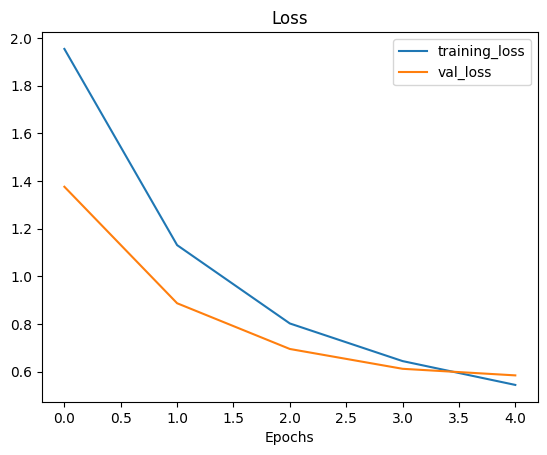

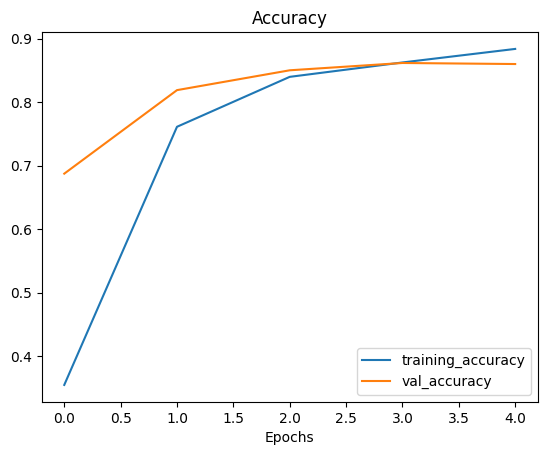

In [18]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)